# Simulation MORDOR SD

# Import module


In [34]:
import numpy as np
import matplotlib.pyplot as plt
from mordor_sd_assim import mordor_sd
import datetime
import litres
from save_tools import *

#  Arrays definitions

In [35]:

""" Arrays sizes definition
npmt : number of parameters
ncond: number of initial conditions ? to verify
nres : number of results colomns in the final structure
tmax : number of dates pissibly simulated by Mordor
"""
npmt  = 100   
ncond = 72
nres  = 74 #230 
tmax  = 2000


#  Function to read file parameters

In [36]:

def res2pmt(data_file) :
    """Reader of parameters file for the Mordor model
    Input:
    -------
    - data_file: file name to read
    Output:
    -------
    - pmtdict: Dictionnary with parameters
      parameters names can be retrieved with 'names' key
    variables:
    -------
    pmt     : parameters arrays filled by the litres Fortran code
    pmtdict : dictionnay with all parameters
    name    : names of each parameters
    """
    pmt = np.zeros(npmt)
    
    litres.litres(nomfic=data_file, pmtmor=pmt)
    
    name = ["mod_neige","mod_deriv","mod_lac","mod_etp","mod_glace","mod_out","sbv","pdt","dh","fglace",
           "flac","xlat","z50","ztair","lonR","nstock","cp","cetp","csbv","gtz","gpz","etp1","etp2",
           "kmin","umax","lmax","zmax","evl","kr","lkn","evn","cel","dif","qcel","qdif","kf","kfp","efp",
           "eft","lts","gm","kg","kgp","efg","jg","ptjp1","raym","qext","zs1","fs1","fgi1","fgf1","zs2",
           "fs2","fgi2","fgf2","zs3","fs3","fgi3","fgf3","zs4","fs4","fgi4","fgf4","zs5","fs5","fgi5","fgf5",
           "zs6","fs6","fgi6","fgf6","zs7","fs7","fgi7","fgf7","zs8","fs8","fgi8","fgf8","zs9","fs9","fgi9",
           "fgf9","zs10","fs10","fgi10","fgf10","nsbv","qres","lqs","x92","x93","x94","x95","x96","x97","x98","x99","x100"]
    
    pmtdict={}
    
    for i in range(npmt):
        pmtdict[name[i]] = pmt[i]
    pmtdict['names'] = name
    return pmtdict


# Mordor calculation function

In [37]:

def Calcul_MordorSD(Date, QS, NS, PS, TS, pmtdictn, cond=[np.nan]):
    """Driver for MORDOR simulation.
    Inputs:
    -------
    - Date: date objet
    - QS: observed flow rate, for comparison with the simulation
    - PS: precipitation (forcing)
    - TS: surface temperature (forcing)
    - pmtdict: model parameters, read from a parameter files of the type Param_Durance@Clapiere.res with function res2pmt
    Outputs:
    --------
    - dictionary with ("Date","Qobs","PS","T","Qam","rbase","rvers","rsurf", "S", "fneige",
      "U","L","Z","N","ep","er","Qmod","lg","agl")
      products names can be retrieved with the 'names' key
    variables:
    --------
    pmt  : parameters arrays filled by using the pmtdict dictionnary
    npdt : number of date to simulate
    JJ   : julian days computed from Date
    don  : an array with JJ,QS,PS,TS as input of the Mordor model
    res0 : output array
    init : integer (0 or 1) to initialise the Model set to 1
    cond         : array as input of the Mordor model, initial conditions ? to ask to EDF
    don_f, pmt_f, cond_f and res0_f: as respectively the arrays don, pmt, cond and res0
                   converted in arrays using Fortran-like index order
    RES          : dictionnary containing all products results
    RES['names'] : names on each product
  
    """

    pmt = np.zeros(npmt)
    for i_n in range(npmt):
        pmt[i_n] = pmtdict[pmtdict['names'][i_n]]
    
    npdt=len(Date)
    
    # julian days computation
    JJ = list()
    for id in Date: JJ.append(id.timetuple().tm_yday)
    
    don = np.zeros((tmax, 4))
    don[0:npdt,0] = np.asarray(JJ)
    don[0:npdt,1] = np.asarray(QS)
    don[0:npdt,2] = np.asarray(PS)
    don[0:npdt,3] = np.asarray(TS)

    res0 = np.zeros((tmax, nres))
    
    if cond[0]!=cond[0]: # initialization given 
        init = 0
        cond = np.zeros(ncond)+1
    else: # on donne l'initialisation
        init = 0

    cond[0] = npdt
    
    # creation of arrays using Fortran-like index order
    don_f  = np.array(don, dtype=np.float, order='F')
    pmt_f  = np.array(pmt, dtype=np.float, order='F')
    cond_f = np.array(cond, dtype=np.float, order='F')
    res0_f = np.array(res0, dtype=np.float, order='F')
    
    mordor_sd(don_f, pmt_f, cond_f, res0_f, init)
    

    # outputs data storage
    RES = {}
       # list of the names of each column in the outputs (in the same order as in the fortran)
    list_res   = ["Q", "fneige", "S", "N",
          "U_1", "U_2", "U_3", "U_4", "U_5", "U_6", "U_7", "U_8", "U_9", "U_10",
         "L_1", "L_2", "L_3", "L_4", "L_5", "L_6", "L_7", "L_8", "L_9", "L_10",
         "Z_1", "Z_2", "Z_3", "Z_4", "Z_5", "Z_6", "Z_7", "Z_8", "Z_9", "Z_10",
         "S_1", "S_2", "S_3", "S_4", "S_5", "S_6", "S_7", "S_8", "S_9", "S_10",
         "sns_1", "sns_2", "sns_3", "sns_4", "sns_5", "sns_6", "sns_7", "sns_8", "sns_9", "sns_10",
         "snl_1", "snl_2", "snl_3", "snl_4", "snl_5", "snl_6", "snl_7", "snl_8", "snl_9", "snl_10",
         "tst_1", "tst_2", "tst_3", "tst_4", "tst_5", "tst_6", "tst_7", "tst_8", "tst_9", "tst_10"]

    RES['names']  = list_res
    
    RES['Date']   = Date[0:npdt]
    RES['Qobs']   = np.asarray(QS[0:npdt])
    RES['Sobs']   = np.asarray(NS[0:npdt])
    RES['PS']     = np.asarray(PS[0:npdt])
    RES['T']      = np.asarray(TS[0:npdt])
    
    # filling the RES dictionary with each Mordor output
    for i_r in range(nres):
        RES[list_res[i_r]] = res0_f[0:npdt,i_r]


    return RES

# Auto-regressif model

In [38]:
def AR1(nb, phi, s):

    """ Autoregressive model of order one
    Inputs:
    -------
    - nb : size of sample
    - phi: phi parameter ( exp(-dt/tau) )
    - var: scale of the white noise
    --------
    - Outputs
    --------
    - x: autoregressive model result
    """
    
    # array of same size as forcings +1
    x = np.empty(nb+1)
    
    # first element is set to 0
    x[0]=0.
    
    # array containing random values (Gaussian dstribution
    # with zero mean and standard deviation of s
    eps=np.random.normal(0, s, nb)
    
    # Autoregressive model of order one
    # Loop on each step, using previous value and random values
    # using formula :  x[i+1]=x[i]*phi+eps[i]
    for i in range(nb):
        x[i+1]=x[i]*phi+eps[i]
    
    # return result excepted first step (set to 0)
    return x[1:]

# Data and parameter files

In [39]:
data       = "QPThisto_J_isere@bvi_coche_ponserand_valid.txt"
data2      = "SWE_NRC_NDAout.txt"
file_param = "isere_FINAL_J_SIM.res"#"FINAL_J_SIM.res"

In [40]:


"""
Initialization interface
- d_ini_known  : beginning forcing date (format: YYYY-MM-DD)
- d_end_known  : end forcing date
- d_ini_FP     : beginning particles filter

"""

year = 2017

d_ini_known   = str(year-3) + "-09-01"
d_end_known   = str(year)   + "-08-31"

phi_P= 0.25
phi_T= 0.95
# variance of perturbations 0.18
std_P= 0.35 * 1.
std_T= 0.55 * 1.

# Ensemble size
N_p = 50 #50
###


In [41]:
#output filename (which will contain the outputs of Mordor)

save_file_n = "Ensemble_50_verites_"+str(year)+".nc"


# parameters reading
pmtdict = res2pmt(file_param)

# output mode of Mordor (specific to the wrapper)
pmtdict["mod_out"] = 3

#####################################################################
#####################################################################

# date objets creations
d_ikn = datetime.datetime.strptime(d_ini_known, '%Y-%m-%d')
d_ekn = datetime.datetime.strptime(d_end_known, '%Y-%m-%d')


Qobs   = list()
PS     = list()
TS     = list()
date_l = list()

#fmt   = '%d/%m/%Y' #'01/01/1948'

# observations file reading, Q
QPT = open(data)
il=0
i_dt = 0
for iline in QPT:
    tmp_line = iline.split()
    il += 1
    if il==1: continue
    dt = datetime.datetime.strptime(tmp_line[0][1:11], '%d/%m/%Y')
    # if date before start init then: continue
    if (dt < d_ikn): continue
    #if  date before end init then: continue #
    if (dt > d_ekn): continue
    i_dt += 1
    date_l.append(dt)
    Qobs.append(float(tmp_line[1]))
    PS.append(float(tmp_line[2]))
    TS.append(float(tmp_line[3]))

QPT.close()

In [42]:
# observations file reading, NRC (snow)

Sobs   = list()
date_l2 = list()

QPT2 = open(data2)
il=0
i_dt = 0
for iline in QPT2:
    tmp_line = iline.split()
    il += 1
    if il==1: continue
    dt = datetime.datetime.strptime(tmp_line[0][1:11], '%d/%m/%Y')
    # si date avant debut init alors: continue
    if (dt < d_ikn): continue
    # si date avant fin init alors: continue
    if (dt > d_ekn): continue
    i_dt += 1
    date_l2.append(dt)
    Sobs.append(float(tmp_line[1]))

QPT2.close()

In [43]:
### replace -9999 by Nan in observations data
ind999 = np.where((np.asarray(Qobs)<-9000.)+(np.asarray(Sobs)<-9000.))[0]

for i_ind in ind999:
    Qobs[i_ind]=np.nan
    Sobs[i_ind]=np.nan

# nb of dates
npdt = len(date_l)

### perturbed PS and T ensemble creation

Q_obs      = np.zeros(npdt)
Q_ens      = np.zeros((npdt, N_p))
S_obs      = np.zeros(npdt)
S_ens      = np.zeros((npdt, N_p))
S_n_ens    = np.zeros((npdt, 10, N_p)) 

fneige_ens = np.zeros((npdt, N_p))
PS_ens     = np.zeros((npdt, N_p))
T_ens      = np.zeros((npdt, N_p))

# perturbations of PS and TS over the entire initialization period
for ip in range(N_p):
    X_P = AR1( npdt, phi_P, std_P) + 1
    X_T = AR1( npdt, phi_T, std_T)
    #
    PS_ens[:, ip] = np.asarray(PS) * X_P
    T_ens[:, ip]  = np.asarray(TS) + X_T



In [44]:
# Mordor calling

for i_per in range(N_p):
    RES = Calcul_MordorSD(date_l[:], Qobs, Sobs, PS_ens[:, i_per], T_ens[:, i_per], pmtdict)    
    Q_obs[:]             = RES['Qobs'][:]
    S_obs[:]             = RES['Sobs'][:]
    Q_ens[:, i_per]      = RES['Q'][:]
    S_ens[:, i_per]      = RES['S'][:]
    S_n_ens[:, 0, i_per] = RES['S_1'][:]
    S_n_ens[:, 1, i_per] = RES['S_2'][:]
    S_n_ens[:, 2, i_per] = RES['S_3'][:]
    S_n_ens[:, 3, i_per] = RES['S_4'][:]
    S_n_ens[:, 4, i_per] = RES['S_5'][:]
    S_n_ens[:, 5, i_per] = RES['S_6'][:]
    S_n_ens[:, 6, i_per] = RES['S_7'][:]
    S_n_ens[:, 7, i_per] = RES['S_8'][:]
    S_n_ens[:, 8, i_per] = RES['S_9'][:]
    S_n_ens[:, 9, i_per] = RES['S_10'][:]
    fneige_ens[:, i_per] = RES['fneige'][:]
    PS_ens[:, i_per]     = RES['PS'][:]
    T_ens[:, i_per]      = RES['T'][:]

# Saving to external files

In [45]:

print('Saving outputs...')

# preparation of dates values in float arrays format

DATE       = np.zeros((5, npdt)) #YYYY, mm, dd, HH, MM

for i_t in range(npdt):
    DATE[0, i_t] = date_l[i_t].year
    DATE[1, i_t] = date_l[i_t].month
    DATE[2, i_t] = date_l[i_t].day
    DATE[3, i_t] = date_l[i_t].hour
    DATE[4, i_t] = date_l[i_t].minute

    # all is registered in a dictionary


data_out = {}

data_out['Q_obs']      = Q_obs[:]
data_out['S_obs']      = S_obs[:]

data_out['Q_ens']      = Q_ens[:, :]
data_out['S_ens']      = S_ens[:, :]
data_out['S_1_ens']    = S_n_ens[:, 0, :]
data_out['S_2_ens']    = S_n_ens[:, 1, :]
data_out['S_3_ens']    = S_n_ens[:, 2, :]
data_out['S_4_ens']    = S_n_ens[:, 3, :]
data_out['S_5_ens']    = S_n_ens[:, 4, :]
data_out['S_6_ens']    = S_n_ens[:, 5, :]
data_out['S_7_ens']    = S_n_ens[:, 6, :]
data_out['S_8_ens']    = S_n_ens[:, 7, :]
data_out['S_9_ens']    = S_n_ens[:, 8, :]
data_out['S_10_ens']   = S_n_ens[:, 9, :]

data_out['fneige_ens'] = fneige_ens[:, :]
data_out['PS_ens']     = PS_ens[:, :]
data_out['T_ens']      = T_ens[:, :]
data_out['PS']         = PS
data_out['TS']         = TS
data_out['DATE']       = DATE[:, :]

# stored the dictionary in NetCdf file
rec_tabs(data_out, save_file_n)


Saving outputs...


# Plots

In [46]:
########### PLOT

d_ini_plot = str(year-1) + "-09-01"

d_plt = datetime.datetime.strptime(d_ini_plot, '%Y-%m-%d')
ind_deb_plot = np.where(np.asarray(date_l)==d_plt)[0][0]

type_graph=0

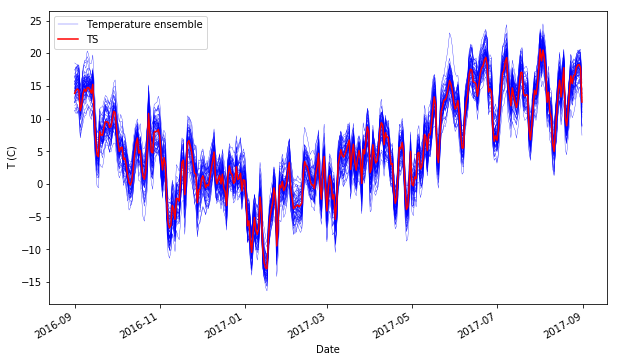

In [47]:
# plot T

if type_graph==0:
    fig = plt.figure(1, figsize=(10, 6))
    for i_e in range(N_p):
        
       # if i_e not in [2, 5, 8]: continue

        if i_e==0:
            plt.plot(date_l[ind_deb_plot:], T_ens[ind_deb_plot:, i_e], '-b', label='Temperature ensemble', linewidth=0.3)
        else:
            plt.plot(date_l[ind_deb_plot:], T_ens[ind_deb_plot:, i_e], '-b', linewidth=0.3)

    plt.plot(date_l[ind_deb_plot:], TS[ind_deb_plot:],'r', label="TS")
    plt.xlabel("Date")
    plt.ylabel('T (C)')

    plt.gcf().autofmt_xdate()
    plt.legend()
    plt.show()

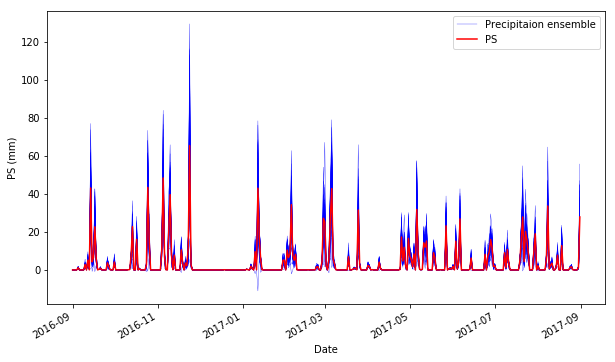

In [48]:
# plot PS

if type_graph==0:
    fig = plt.figure(1, figsize=(10, 6))
    for i_e in range(N_p):
        
       # if i_e not in [2, 5, 8]: continue

        if i_e==0:

            plt.plot(date_l[ind_deb_plot:], PS_ens[ind_deb_plot:, i_e], '-b', label='Precipitaion ensemble', linewidth=0.3)
        else:
            plt.plot(date_l[ind_deb_plot:], PS_ens[ind_deb_plot:, i_e], '-b', linewidth=0.3)

    plt.plot(date_l[ind_deb_plot:], PS[ind_deb_plot:],'r', label="PS")
    plt.xlabel("Date")
    plt.ylabel('PS (mm)')

    plt.gcf().autofmt_xdate()
    plt.legend()
    plt.show()


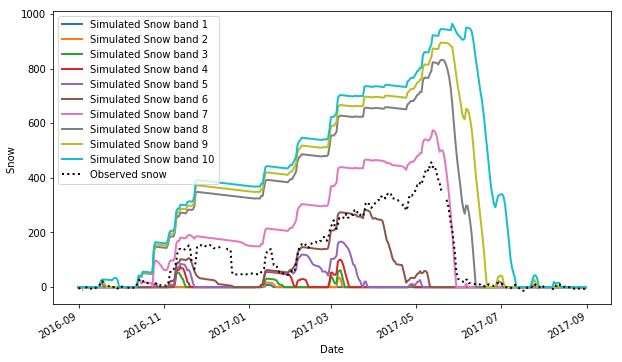

In [49]:
# plot 10 levels of S for verite=i_ver
i_ver = 0

if type_graph==0:
    
    fig = plt.figure(1, figsize=(10, 6))
    
    for i_b in range(10):
    
        #ind999 = np.where(S_obs <0.)[0]
        #S_obs[ind999]    = np.nan

        plt.plot(date_l[ind_deb_plot:], S_n_ens[ind_deb_plot:, i_b, i_ver], label='Simulated Snow band '+str(i_b+1), linewidth=2)
    
#    plt.plot(date_l[ind_deb_plot:], S_ens[ind_deb_plot:, 0], '--b', label='Simulated Snow S')
    plt.plot(date_l[ind_deb_plot:], S_obs[ind_deb_plot:],':k',  label="Observed snow", linewidth=2)
   # plt.plot(date_l[ind_deb_plot:], Q_obs[ind_deb_plot:],':r',  label="Observed flow", linewidth=4)


    plt.xlabel("Date")
    plt.ylabel('Snow ')

    plt.gcf().autofmt_xdate()
    plt.legend()
    plt.show()


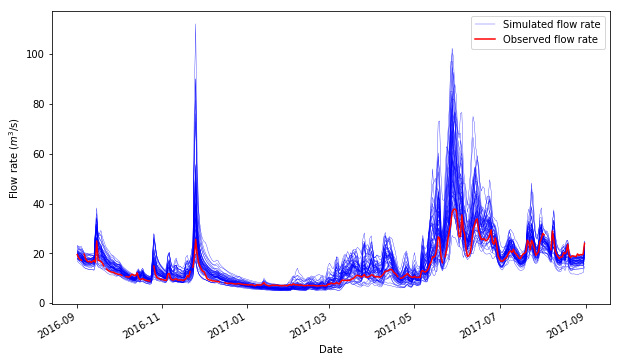

In [50]:

# plot Q


if type_graph==0:
    fig = plt.figure(1, figsize=(10, 6))

    
    for i_e in range(N_p):
        if i_e==0:

            plt.plot(date_l[ind_deb_plot:], Q_ens[ind_deb_plot:, i_e], '-b', label='Simulated flow rate', linewidth=0.3)
        else:
            plt.plot(date_l[ind_deb_plot:], Q_ens[ind_deb_plot:, i_e], '-b', linewidth=0.3)
    plt.plot(date_l[ind_deb_plot:], Q_obs[ind_deb_plot:],'r',  label="Observed flow rate")

    plt.xlabel("Date")
    plt.ylabel('Flow rate ($m^3$/s)')
    #plt.ylabel('S (mm)')

    plt.gcf().autofmt_xdate()
    plt.legend()
    plt.show()
